In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from config import root_dir
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tcav.utils import writeTensorsName

In [2]:
batch_size = 64
epochs = 5
num_classes = 25
train_path = root_dir + 'tcav/dataset/for_train/Fruit-Images-Dataset/train'
test_path = root_dir + 'tcav/dataset/for_train/Fruit-Images-Dataset/test'
save_path = root_dir + 'tcav/frozen_models/'
dataset_path = root_dir + 'tcav/dataset/'
save_name = 'fruit_4layers_cnn'
WIDTH = 100
HEIGHT = 100
input_shape = (WIDTH,HEIGHT,3)

In [3]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________

In [4]:
model.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical')

Found 11229 images belonging to 25 classes.
Found 2932 images belonging to 25 classes.


In [6]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
    )

Epoch 1/5
176/176 [==============================] - 63s 359ms/step - loss: 0.9245 - acc: 0.7060 - val_loss: 0.2702 - val_acc: 0.9611
Epoch 2/5
176/176 [==============================] - 63s 356ms/step - loss: 0.1215 - acc: 0.9622 - val_loss: 0.3456 - val_acc: 0.9601
Epoch 3/5
176/176 [==============================] - 62s 355ms/step - loss: 0.0846 - acc: 0.9752 - val_loss: 0.2616 - val_acc: 0.9645
Epoch 4/5
176/176 [==============================] - 62s 355ms/step - loss: 0.0317 - acc: 0.9898 - val_loss: 0.2057 - val_acc: 0.9717
Epoch 5/5
176/176 [==============================] - 62s 355ms/step - loss: 0.0410 - acc: 0.9877 - val_loss: 0.2907 - val_acc: 0.9669


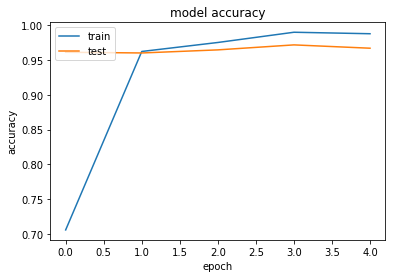

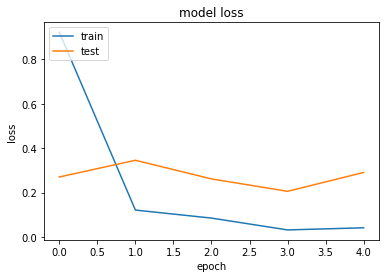

In [8]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
print('epoch {}'.format(epochs))
print('image size {}'.format(WIDTH,HEIGHT))
print('class {}'.format(num_classes))
print('num train data {}'.format(11229))
print('num test data {}'.format(2932))
print('batch_size {}'.format(batch_size))
print('train acc {}'.format(history.history['acc'][-1]))
print('test acc {}'.format(history.history['val_acc'][-1]))

epoch 5
image size 100
class 25
num train data 11229
num test data 2932
batch_size 64
train acc 0.9877104163169861
test acc 0.9669167995452881


In [18]:
# outputのノード名が必要なのでprintして確認する
print(model.output.op.name)
output_node_name = model.output.op.name
#ファイル名を.ckptとしてモデルを保存
saver = tf.train.Saver()
saver.save(K.get_session(), 'frozen_model.ckpt')

dense_2/Softmax


'frozen_model.ckpt'

In [19]:
output_path = save_path + save_name + '.pb'
os.system('python tensorflow/tensorflow/python/tools/freeze_graph.py --input_meta_graph=frozen_model.ckpt.meta --input_checkpoint=frozen_model.ckpt --output_graph={0}  --output_node_names={1} --input_binary=true'.format(output_path,output_node_name))
os.system('rm -rf frozen_model.ckpt*')
os.system('rm checkpoint')

0

In [21]:
output_name_path = output_path[:-3] + '_name'
if os.path.exists(output_name_path) == False:
  writeTensorsName(output_path,output_name_path)

In [5]:
# label保存
with open(dataset_path + 'fruit25_label_string.txt', mode='w') as f:
  for name in train_generator.class_indices.keys():
    f.write(name + '\n')